In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
entries_stats = pd.read_csv("D:\\Nik\\Projects\\mlfmf-poskusi\\stdlib\\entries_stats.tsv", sep="\t")
entries_stats

,file_name,entry_type,num_nodes,num_edges,num_leaves,num_names
0,Agda.Builtin.Bool_0000.dag,constructor,16,15,6,3
1,Agda.Builtin.Bool_0001.dag,data,10,9,4,3
2,Agda.Builtin.Bool_0002.dag,data,10,9,4,3
3,Agda.Builtin.Char.Properties_0000.dag,axiom,91,90,43,9
4,Agda.Builtin.Char_0000.dag,axiom,11,10,4,1
...,...,...,...,...,...,...
16478,Text.Printf_0003.dag,function,685,684,325,73
16479,Text.Printf_0004.dag,function,1154,1153,680,153
16480,Text.Printf_0005.dag,function,382,381,218,57
16481,Text.Printf_0006.dag,function,303,302,171,45


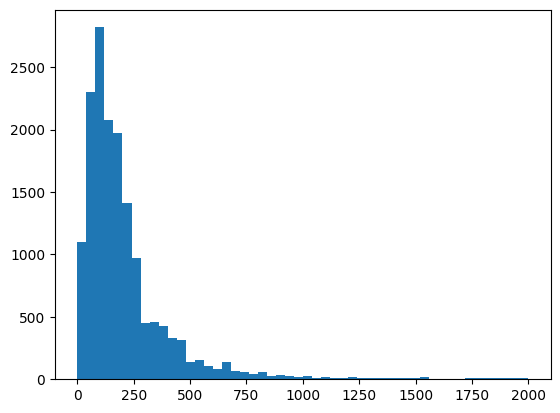

In [3]:
_ = plt.hist(
    entries_stats["num_leaves"], 
    bins=50, 
    range=(0,2000),
    # log=True,
    )

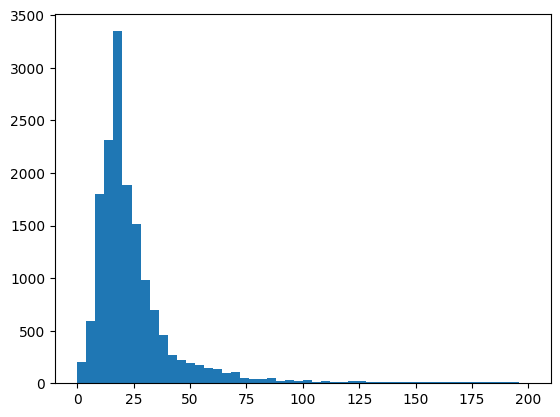

In [4]:
_ = plt.hist(
    entries_stats["num_names"], 
    bins=50, 
    range=(0,200),
    # log=True,
    )

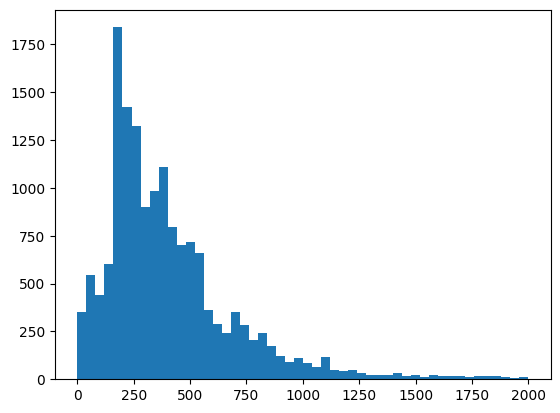

In [5]:
_ = plt.hist(
    entries_stats["num_nodes"], 
    bins=50, 
    range=(0,2000),
    # log=True,
    )

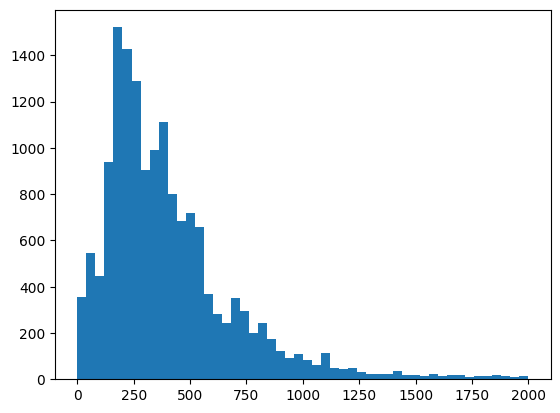

In [6]:
_ = plt.hist(
    entries_stats["num_edges"], 
    bins=50, 
    range=(0,2000),
    # log=True,
    )

In [7]:
function_entries = entries_stats[entries_stats["entry_type"] == "function"].drop("entry_type", axis=1)
function_entries

,file_name,num_nodes,num_edges,num_leaves,num_names
18,Agda.Builtin.Coinduction_0000.dag,48,47,11,4
21,Agda.Builtin.Cubical.Glue_0000.dag,462,461,150,10
22,Agda.Builtin.Cubical.Glue_0001.dag,276,275,64,6
23,Agda.Builtin.Cubical.Glue_0002.dag,386,385,148,26
24,Agda.Builtin.Cubical.Glue_0003.dag,294,293,96,16
...,...,...,...,...,...
16477,Text.Printf_0002.dag,399,398,197,51
16478,Text.Printf_0003.dag,685,684,325,73
16479,Text.Printf_0004.dag,1154,1153,680,153
16480,Text.Printf_0005.dag,382,381,218,57


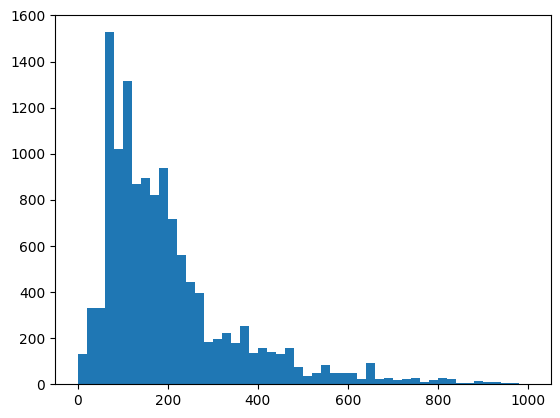

In [10]:
_ = plt.hist(
    function_entries["num_leaves"],
    bins = 50,
    range=(0,1000),
)